In [1]:
import pandas as pd
import numpy as np
import os
import torch
import time
import json

from peft import LoraConfig, LoraModel, get_peft_model, TaskType
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

os.environ["TOKENIZERS_PARALLELISM"] = "false"
use_cuda = torch.cuda.is_available()

2024-08-12 17:43:43.463500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 17:43:45.369240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-08-12 17:43:45.369463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-08-12 17:43:45.369486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [2]:
df = pd.read_csv('dataset/all_data.csv')
train_data = pd.read_csv('dataset/train.csv')
val_data = pd.read_csv('dataset/val.csv')
test_data = pd.read_csv('dataset/test.csv')

# Length train, val, and test
print("Train: ",len(train_data))
print("Val: ",len(val_data))
print("Test: ",len(test_data))

Train:  4956
Val:  1062
Test:  1062


In [3]:
tags = np.unique(df['label'])
num_labels = len(tags)
max_length = 128
label2id = {t: i for i, t in enumerate(tags)}
id2label = {i: t for i, t in enumerate(tags)}

In [4]:
label2id

{'Anger': 0, 'Fear': 1, 'Joy': 2, 'Love': 3, 'Neutral': 4, 'Sad': 5}

In [5]:
def model_init(model_name):
    global tokenizer
    global data_collator
    global tr_model

    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=128)
    
    # Configure LoRA
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, 
        r=8, # Rank of the low-rank matrices
        lora_alpha=32, 
        lora_dropout=0.1
    )
    
    # Wrap the base model with the LoRA configuration
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()
    
    return model, tokenizer


def tokenize_function(examples):
    # process the input sequence
    tokenized_input = tokenizer(examples["tweet"], 
                                truncation=True, 
                                padding='max_length', 
                                max_length=max_length)
    # process the labels
    tokenized_input['label'] = [label2id[lb] for lb in examples['label']]
    
    return tokenized_input


def preprocessing():
    X_train = Dataset.from_pandas(train_data)
    X_val = Dataset.from_pandas(val_data)
    X_test = Dataset.from_pandas(test_data)
    
    tokenized_train_data = X_train.map(tokenize_function, batched=True)
    tokenized_val_data = X_val.map(tokenize_function, batched=True)
    tokenized_test_data = X_test.map(tokenize_function, batched=True)
    
    return tokenized_train_data, tokenized_val_data, tokenized_test_data


def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    
    true_labels = [tags[l] for l in labels] 
    true_predictions = [tags[pr] for pr in pred]

    report = classification_report(true_labels, true_predictions, digits=4)
    acc = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    rec = recall_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    prec = precision_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    f1 = f1_score(y_true=true_labels, y_pred=true_predictions, average="macro", zero_division=1.0)

    print("Classification Report:\n{}".format(report))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [6]:
# to generate the confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

def generate_confusion_matrix(true_labels, pred_labels, num_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    labels = [id2label[i] for i in range(num_labels)]
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, 
                annot=True, 
                fmt="d", 
                cmap="Blues", 
                xticklabels=labels, 
                yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.yticks(rotation=0)
    plt.show()

In [7]:
def train_model(model_name, output_dir, learning_rate, train_batch_size, eval_batch_size, num_epochs, weight_decay):

    model, tokenizer = model_init(model_name)
    train_tokenized, val_tokenized, test_tokenized = preprocessing()
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit = 1,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        #push_to_hub=True, # to push to hub during the training
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    trainer.save_model(output_dir)
    #trainer.push_to_hub(commit_message="Training complete")
    
    # Get the evaluation results
    trainer.eval_dataset=test_tokenized
    evaluation_results = trainer.evaluate()
    print(evaluation_results)
    
    # make prediction on the test set
    predictions = trainer.predict(test_tokenized)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = test_tokenized["label"]
    
    # Generate confusion matrix
    generate_confusion_matrix(true_labels, pred_labels, num_labels)
    
    return trainer

In [8]:
def show_log_history(trainer):
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.fillna(0)
    log_history = log_history.groupby(["epoch"]).sum()
    
    log_history[["loss", "eval_loss"]].plot()
    plt.show()

In [9]:
def main(model_name, output_dir, best_params):
    start = time.time()
     # load json file containing best params
    best_params = best_params

    with open(best_params, 'r') as js:
        data = json.load(js)

    print(data)

    # define best params
    num_train_epochs = data['num_train_epochs']
    learning_rate = data['learning_rate']
    train_batch_size = data['per_device_train_batch_size']
    eval_batch_size = data['per_device_eval_batch_size']
    weight_decay = data['weight_decay']

    # training
    tr_model = train_model(model_name=model_name, 
                           output_dir=output_dir,
                           learning_rate=learning_rate,
                           train_batch_size=train_batch_size,
                           eval_batch_size=eval_batch_size,
                           num_epochs=num_train_epochs,
                           weight_decay=weight_decay)

    print('Training finished!')
    
    show_log_history(tr_model)

    
    end = time.time()
    exec_time = (end - start) / 60
    print(f'Total time: {exec_time} minutes')

{'num_train_epochs': 8, 'learning_rate': 0.0001, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8, 'weight_decay': 0.0921104871708941}


Some weights of the model checkpoint at indolem/indobertweet-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/ind

trainable params: 299,526 || all params: 110,862,348 || trainable%: 0.27017829353569167


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4956
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 624
  Number of trainable parameters = 299526
Automatic Weights & Biases logging enabled, to di

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.673400,1.549178,0.419021,0.574639,0.325919,0.316611
2,1.358600,1.114445,0.674200,0.706719,0.655182,0.672582
3,1.032300,0.909809,0.710923,0.734780,0.703682,0.713503
4,0.879000,0.816966,0.734463,0.744246,0.734682,0.738417
5,0.796000,0.775589,0.737288,0.739265,0.749169,0.743064
6,0.757900,0.748601,0.740113,0.743040,0.750722,0.745833
7,0.734400,0.734882,0.753296,0.759535,0.760767,0.759300
8,0.726800,0.733043,0.748588,0.754757,0.759736,0.756163


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.5158    0.2784    0.3616       176
        Fear     0.5500    0.0748    0.1317       147
         Joy     0.6187    0.4859    0.5443       177
        Love     0.8667    0.1130    0.2000       115
     Neutral     0.3550    0.9161    0.5117       298
         Sad     0.5417    0.0872    0.1503       149

    accuracy                         0.4190      1062
   macro avg     0.5746    0.3259    0.3166      1062
weighted avg     0.5342    0.4190    0.3552      1062



Saving model checkpoint to p-emotcls-indobertweet-base/checkpoint-78
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-indobertweet-base/checkpoint-78/tokenizer_config.json
Special tokens file saved in p-emotcls-indobertweet-base/checkpoint-78/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples

Classification Report:
              precision    recall  f1-score   support

       Anger     0.6473    0.7614    0.6997       176
        Fear     0.7913    0.6190    0.6947       147
         Joy     0.7101    0.6780    0.6936       177
        Love     0.7722    0.5304    0.6289       115
     Neutral     0.5995    0.7383    0.6617       298
         Sad     0.7200    0.6040    0.6569       149

    accuracy                         0.6742      1062
   macro avg     0.7067    0.6552    0.6726      1062
weighted avg     0.6880    0.6742    0.6737      1062



Saving model checkpoint to p-emotcls-indobertweet-base/checkpoint-156
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-indobertweet-base/checkpoint-156/tokenizer_config.json
Special tokens file saved in p-emotcls-indobertweet-base/checkpoint-156/special_tokens_map.json
Deleting older checkpoint [p-emotcls-indobertweet-base/checkpoint-78] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClass

Classification Report:
              precision    recall  f1-score   support

       Anger     0.6478    0.8466    0.7340       176
        Fear     0.8254    0.7075    0.7619       147
         Joy     0.7440    0.7062    0.7246       177
        Love     0.7614    0.5826    0.6601       115
     Neutral     0.6531    0.7013    0.6764       298
         Sad     0.7769    0.6779    0.7240       149

    accuracy                         0.7109      1062
   macro avg     0.7348    0.7037    0.7135      1062
weighted avg     0.7203    0.7109    0.7107      1062



Saving model checkpoint to p-emotcls-indobertweet-base/checkpoint-234
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-indobertweet-base/checkpoint-234/tokenizer_config.json
Special tokens file saved in p-emotcls-indobertweet-base/checkpoint-234/special_tokens_map.json
Deleting older checkpoint [p-emotcls-indobertweet-base/checkpoint-156] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClas

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7461    0.8182    0.7805       176
        Fear     0.7973    0.8027    0.8000       147
         Joy     0.7514    0.7345    0.7429       177
        Love     0.7383    0.6870    0.7117       115
     Neutral     0.6785    0.7081    0.6929       298
         Sad     0.7538    0.6577    0.7025       149

    accuracy                         0.7345      1062
   macro avg     0.7442    0.7347    0.7384      1062
weighted avg     0.7353    0.7345    0.7340      1062



Saving model checkpoint to p-emotcls-indobertweet-base/checkpoint-312
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-indobertweet-base/checkpoint-312/tokenizer_config.json
Special tokens file saved in p-emotcls-indobertweet-base/checkpoint-312/special_tokens_map.json
Deleting older checkpoint [p-emotcls-indobertweet-base/checkpoint-234] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClas

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7551    0.8409    0.7957       176
        Fear     0.7961    0.8231    0.8094       147
         Joy     0.7330    0.7288    0.7309       177
        Love     0.6850    0.7565    0.7190       115
     Neutral     0.7091    0.6544    0.6806       298
         Sad     0.7574    0.6913    0.7228       149

    accuracy                         0.7373      1062
   macro avg     0.7393    0.7492    0.7431      1062
weighted avg     0.7369    0.7373    0.7360      1062



Saving model checkpoint to p-emotcls-indobertweet-base/checkpoint-390
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-indobertweet-base/checkpoint-390/tokenizer_config.json
Special tokens file saved in p-emotcls-indobertweet-base/checkpoint-390/special_tokens_map.json
Deleting older checkpoint [p-emotcls-indobertweet-base/checkpoint-312] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClas

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7487    0.8466    0.7947       176
        Fear     0.7898    0.8435    0.8158       147
         Joy     0.7360    0.7401    0.7380       177
        Love     0.7155    0.7217    0.7186       115
     Neutral     0.7091    0.6544    0.6806       298
         Sad     0.7591    0.6980    0.7273       149

    accuracy                         0.7401      1062
   macro avg     0.7430    0.7507    0.7458      1062
weighted avg     0.7390    0.7401    0.7385      1062



Saving model checkpoint to p-emotcls-indobertweet-base/checkpoint-468
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-indobertweet-base/checkpoint-468/tokenizer_config.json
Special tokens file saved in p-emotcls-indobertweet-base/checkpoint-468/special_tokens_map.json
Deleting older checkpoint [p-emotcls-indobertweet-base/checkpoint-390] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClas

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7641    0.8466    0.8032       176
        Fear     0.8077    0.8571    0.8317       147
         Joy     0.7879    0.7345    0.7602       177
        Love     0.7304    0.7304    0.7304       115
     Neutral     0.7007    0.6913    0.6959       298
         Sad     0.7664    0.7047    0.7343       149

    accuracy                         0.7533      1062
   macro avg     0.7595    0.7608    0.7593      1062
weighted avg     0.7530    0.7533    0.7523      1062



Saving model checkpoint to p-emotcls-indobertweet-base/checkpoint-546
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-indobertweet-base/checkpoint-546/tokenizer_config.json
Special tokens file saved in p-emotcls-indobertweet-base/checkpoint-546/special_tokens_map.json
Deleting older checkpoint [p-emotcls-indobertweet-base/checkpoint-468] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClas

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7413    0.8466    0.7905       176
        Fear     0.8117    0.8503    0.8306       147
         Joy     0.7784    0.7345    0.7558       177
        Love     0.7227    0.7478    0.7350       115
     Neutral     0.7007    0.6678    0.6838       298
         Sad     0.7737    0.7114    0.7413       149

    accuracy                         0.7486      1062
   macro avg     0.7548    0.7597    0.7562      1062
weighted avg     0.7484    0.7486    0.7474      1062



Saving model checkpoint to p-emotcls-indobertweet-base/checkpoint-624
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-indobertweet-base/checkpoint-624/tokenizer_config.json
Special tokens file saved in p-emotcls-indobertweet-base/checkpoint-624/special_tokens_map.json
Deleting older checkpoint [p-emotcls-indobertweet-base/checkpoint-546] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from p-emotcls-indobertweet-base/checkpoint-624 (score: 0.7330425381660461).
Saving model checkpoint to p-emotcls-indobertweet-base
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-indobertweet-base/tokenizer_config.json
Special tokens file saved in p-emotcls-indobertweet-base/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSeq

The following columns in the test set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: token_type_ids, tweet, index. If token_type_ids, tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7638    0.8444    0.8021       180
        Fear     0.7852    0.8731    0.8269       134
         Joy     0.8154    0.7644    0.7891       208
        Love     0.7248    0.7822    0.7524       101
     Neutral     0.7343    0.6838    0.7082       291
         Sad     0.7770    0.7297    0.7526       148

    accuracy                         0.7665      1062
   macro avg     0.7668    0.7796    0.7719      1062
weighted avg     0.7667    0.7665    0.7653      1062

{'eval_loss': 0.703019380569458, 'eval_accuracy': 0.7664783427495292, 'eval_precision': 0.7667508354720525, 'eval_recall': 0.7796264324213502, 'eval_f1': 0.771871178942133, 'eval_runtime': 12.1003, 'eval_samples_per_second': 87.766, 'eval_steps_per_second': 2.81, 'epoch': 8.0}


/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7638    0.8444    0.8021       180
        Fear     0.7852    0.8731    0.8269       134
         Joy     0.8154    0.7644    0.7891       208
        Love     0.7248    0.7822    0.7524       101
     Neutral     0.7343    0.6838    0.7082       291
         Sad     0.7770    0.7297    0.7526       148

    accuracy                         0.7665      1062
   macro avg     0.7668    0.7796    0.7719      1062
weighted avg     0.7667    0.7665    0.7653      1062



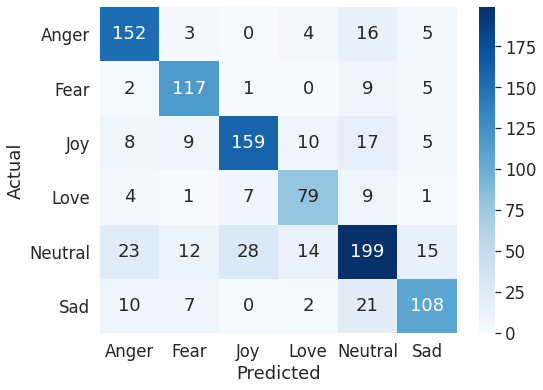

Training finished!


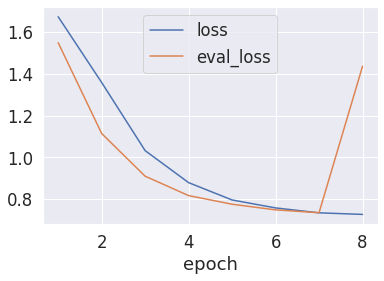

Total time: 8.704496403535208 minutes


In [10]:
#1 IndoBERTweet peft

main(
    model_name = 'indolem/indobertweet-base-uncased',
    output_dir = 'p-emotcls-indobertweet-base',
    best_params = 'best_params/p-indobertweet.json'
)

{'num_train_epochs': 10, 'learning_rate': 0.0003, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8, 'weight_decay': 0.05332656928607487}


loading configuration file config.json from cache at /home/jupyter-145230403/.cache/huggingface/hub/models--FacebookAI--xlm-roberta-large/snapshots/c23d21b0620b635a76227c604d44e43a9f0ee389/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "FacebookAI/xlm-roberta-large",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "Anger",
    "1": "Fear",
    "2": "Joy",
    "3": "Love",
    "4": "Neutral",
    "5": "Sad"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "Anger": 0,
    "Fear": 1,
    "Joy": 2,
    "Love": 3,
    "Neutral": 4,
    "Sad": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_to

trainable params: 1,842,182 || all params: 561,738,764 || trainable%: 0.32794283002338787


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4956
  Num Epochs = 10
  Instan

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.585800,0.884242,0.686441,0.707617,0.691313,0.690722
2,0.831900,0.712290,0.746704,0.749764,0.766580,0.755207
3,0.700100,0.645954,0.758004,0.767204,0.770311,0.767633
4,0.626100,0.646312,0.763653,0.764444,0.780781,0.770773
5,0.554300,0.654962,0.766478,0.768968,0.787318,0.774223
6,0.517800,0.632166,0.775895,0.779214,0.787601,0.781919
7,0.492700,0.637864,0.772128,0.777820,0.783964,0.780025
8,0.459800,0.645747,0.770245,0.767829,0.792042,0.777374
9,0.440300,0.643894,0.776836,0.782715,0.788353,0.784770
10,0.415100,0.644254,0.776836,0.779057,0.791226,0.784026


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.6077    0.7216    0.6597       176
        Fear     0.8587    0.5374    0.6611       147
         Joy     0.7712    0.6667    0.7152       177
        Love     0.6767    0.7826    0.7258       115
     Neutral     0.6569    0.6745    0.6656       298
         Sad     0.6746    0.7651    0.7170       149

    accuracy                         0.6864      1062
   macro avg     0.7076    0.6913    0.6907      1062
weighted avg     0.7003    0.6864    0.6860      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-78
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-78/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-78/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7317    0.8523    0.7874       176
        Fear     0.8146    0.8367    0.8255       147
         Joy     0.7228    0.7514    0.7368       177
        Love     0.6715    0.8000    0.7302       115
     Neutral     0.7371    0.6208    0.6740       298
         Sad     0.8209    0.7383    0.7774       149

    accuracy                         0.7467      1062
   macro avg     0.7498    0.7666    0.7552      1062
weighted avg     0.7492    0.7467    0.7448      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-156
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-156/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-156/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-large/checkpoint-78] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7637    0.7898    0.7765       176
        Fear     0.8289    0.8571    0.8428       147
         Joy     0.7925    0.7119    0.7500       177
        Love     0.7023    0.8000    0.7480       115
     Neutral     0.6957    0.6980    0.6968       298
         Sad     0.8201    0.7651    0.7917       149

    accuracy                         0.7580      1062
   macro avg     0.7672    0.7703    0.7676      1062
weighted avg     0.7597    0.7580    0.7579      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-234
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-234/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-234/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-large/checkpoint-156] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7833    0.8011    0.7921       176
        Fear     0.8378    0.8435    0.8407       147
         Joy     0.7035    0.7910    0.7447       177
        Love     0.6767    0.7826    0.7258       115
     Neutral     0.7677    0.6544    0.7065       298
         Sad     0.8176    0.8121    0.8148       149

    accuracy                         0.7637      1062
   macro avg     0.7644    0.7808    0.7708      1062
weighted avg     0.7664    0.7637    0.7629      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-312
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-312/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-312/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7449    0.8295    0.7849       176
        Fear     0.8581    0.8639    0.8610       147
         Joy     0.6860    0.8023    0.7396       177
        Love     0.6788    0.8087    0.7381       115
     Neutral     0.8043    0.6342    0.7092       298
         Sad     0.8417    0.7852    0.8125       149

    accuracy                         0.7665      1062
   macro avg     0.7690    0.7873    0.7742      1062
weighted avg     0.7738    0.7665    0.7655      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-390
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-390/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-390/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-large/checkpoint-312] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7790    0.8011    0.7899       176
        Fear     0.8662    0.8367    0.8512       147
         Joy     0.7514    0.7684    0.7598       177
        Love     0.6835    0.8261    0.7480       115
     Neutral     0.7607    0.7148    0.7370       298
         Sad     0.8345    0.7785    0.8056       149

    accuracy                         0.7759      1062
   macro avg     0.7792    0.7876    0.7819      1062
weighted avg     0.7788    0.7759    0.7762      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-468
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-468/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-468/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-large/checkpoint-234] due to args.save_total_limit
Deleting older checkpoint [p-emotcls-xlm-r-large/checkpoint-390] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7474    0.8239    0.7838       176
        Fear     0.8643    0.8231    0.8432       147
         Joy     0.7368    0.7910    0.7629       177
        Love     0.7500    0.7826    0.7660       115
     Neutral     0.7546    0.6913    0.7215       298
         Sad     0.8138    0.7919    0.8027       149

    accuracy                         0.7721      1062
   macro avg     0.7778    0.7840    0.7800      1062
weighted avg     0.7734    0.7721    0.7718      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-546
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-546/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-546/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7647    0.8125    0.7879       176
        Fear     0.8258    0.8707    0.8477       147
         Joy     0.7460    0.7966    0.7705       177
        Love     0.7037    0.8261    0.7600       115
     Neutral     0.7925    0.6409    0.7087       298
         Sad     0.7742    0.8054    0.7895       149

    accuracy                         0.7702      1062
   macro avg     0.7678    0.7920    0.7774      1062
weighted avg     0.7726    0.7702    0.7683      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-624
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-624/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-624/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-large/checkpoint-546] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7647    0.8125    0.7879       176
        Fear     0.8768    0.8231    0.8491       147
         Joy     0.7448    0.8079    0.7751       177
        Love     0.7541    0.8000    0.7764       115
     Neutral     0.7545    0.7013    0.7270       298
         Sad     0.8014    0.7852    0.7932       149

    accuracy                         0.7768      1062
   macro avg     0.7827    0.7884    0.7848      1062
weighted avg     0.7780    0.7768    0.7766      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-702
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-702/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-702/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-large/checkpoint-624] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7604    0.8295    0.7935       176
        Fear     0.8389    0.8503    0.8446       147
         Joy     0.7527    0.7910    0.7713       177
        Love     0.7244    0.8000    0.7603       115
     Neutral     0.7669    0.6846    0.7234       298
         Sad     0.8310    0.7919    0.8110       149

    accuracy                         0.7768      1062
   macro avg     0.7791    0.7912    0.7840      1062
weighted avg     0.7778    0.7768    0.7761      1062



Saving model checkpoint to p-emotcls-xlm-r-large/checkpoint-780
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/checkpoint-780/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/checkpoint-780/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-large/checkpoint-702] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from p-emotcls-xlm-r-large/checkpoint-468 (score: 0.6321663856506348).
Deleting older checkpoint [p-emotcls-xlm-r-large/checkpoint-780] due to args.save_total_limit
Saving model checkpoint to p-emotcls-xlm-r-large
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-large/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-large/special_tokens_map.json
The following columns in the evaluation set don't hav

The following columns in the test set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.8362    0.8222    0.8291       180
        Fear     0.8244    0.8060    0.8151       134
         Joy     0.8537    0.8413    0.8475       208
        Love     0.7059    0.8317    0.7636       101
     Neutral     0.7466    0.7491    0.7479       291
         Sad     0.8333    0.7770    0.8042       148

    accuracy                         0.7985      1062
   macro avg     0.8000    0.8046    0.8012      1062
weighted avg     0.8008    0.7985    0.7990      1062

{'eval_loss': 0.5872529149055481, 'eval_accuracy': 0.7984934086629002, 'eval_precision': 0.8000058730553424, 'eval_recall': 0.8045649356894594, 'eval_f1': 0.8012286174836261, 'eval_runtime': 22.9243, 'eval_samples_per_second': 46.326, 'eval_steps_per_second': 1.483, 'epoch': 10.0}


/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

       Anger     0.8362    0.8222    0.8291       180
        Fear     0.8244    0.8060    0.8151       134
         Joy     0.8537    0.8413    0.8475       208
        Love     0.7059    0.8317    0.7636       101
     Neutral     0.7466    0.7491    0.7479       291
         Sad     0.8333    0.7770    0.8042       148

    accuracy                         0.7985      1062
   macro avg     0.8000    0.8046    0.8012      1062
weighted avg     0.8008    0.7985    0.7990      1062



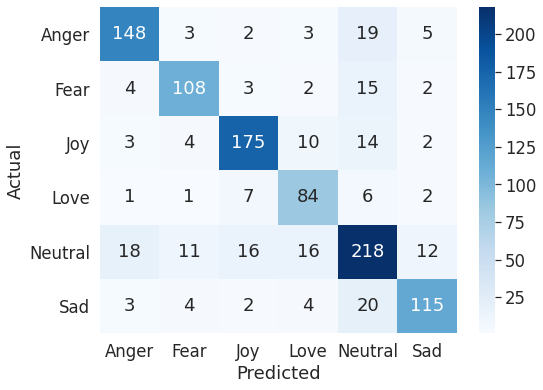

Training finished!


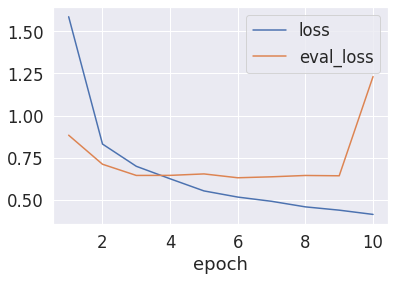

Total time: 19.91166760524114 minutes


In [11]:
#2 FacebookAI/xlm-roberta-large peft

main(
    model_name = 'FacebookAI/xlm-roberta-large',
    output_dir = 'p-emotcls-xlm-r-large',
    best_params = 'best_params/p-xlm-r-large.json'
)

{'num_train_epochs': 9, 'learning_rate': 0.0003, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 64, 'weight_decay': 0.02768291410901637}


loading configuration file config.json from cache at /home/jupyter-145230403/.cache/huggingface/hub/models--FacebookAI--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "FacebookAI/xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Anger",
    "1": "Fear",
    "2": "Joy",
    "3": "Love",
    "4": "Neutral",
    "5": "Sad"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Anger": 0,
    "Fear": 1,
    "Joy": 2,
    "Love": 3,
    "Neutral": 4,
    "Sad": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token

trainable params: 890,118 || all params: 278,938,380 || trainable%: 0.31910918820135115


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4956
  Num Epochs = 9
  Instant

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.663200,1.309070,0.492467,0.617696,0.455443,0.433169
2,1.189000,0.857436,0.694915,0.695018,0.705786,0.698227
3,0.932900,0.809125,0.714689,0.726361,0.738413,0.722371
4,0.838200,0.736432,0.740113,0.739725,0.762405,0.747359
5,0.787300,0.736891,0.732580,0.729405,0.762687,0.740150
6,0.740600,0.703119,0.757062,0.755567,0.781703,0.765384
7,0.716900,0.695696,0.761770,0.759567,0.786213,0.768662
8,0.689500,0.702775,0.760829,0.756160,0.786654,0.767019
9,0.679600,0.685275,0.769303,0.769009,0.787700,0.775763


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 256


Classification Report:
              precision    recall  f1-score   support

       Anger     0.5571    0.2216    0.3171       176
        Fear     1.0000    0.0068    0.0135       147
         Joy     0.5396    0.6158    0.5752       177
        Love     0.6167    0.6435    0.6298       115
     Neutral     0.4202    0.7685    0.5433       298
         Sad     0.5726    0.4765    0.5201       149

    accuracy                         0.4925      1062
   macro avg     0.6177    0.4554    0.4332      1062
weighted avg     0.5857    0.4925    0.4439      1062



Saving model checkpoint to p-emotcls-xlm-r-base/checkpoint-39
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/checkpoint-39/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/checkpoint-39/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 256


Classification Report:
              precision    recall  f1-score   support

       Anger     0.6918    0.6250    0.6567       176
        Fear     0.6319    0.7007    0.6645       147
         Joy     0.7688    0.6949    0.7300       177
        Love     0.7280    0.7913    0.7583       115
     Neutral     0.7148    0.6644    0.6887       298
         Sad     0.6348    0.7584    0.6911       149

    accuracy                         0.6949      1062
   macro avg     0.6950    0.7058    0.6982      1062
weighted avg     0.6987    0.6949    0.6948      1062



Saving model checkpoint to p-emotcls-xlm-r-base/checkpoint-78
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/checkpoint-78/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/checkpoint-78/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-base/checkpoint-39] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** 

Classification Report:
              precision    recall  f1-score   support

       Anger     0.6181    0.8920    0.7302       176
        Fear     0.8130    0.6803    0.7407       147
         Joy     0.7219    0.7627    0.7418       177
        Love     0.7436    0.7565    0.7500       115
     Neutral     0.7892    0.5403    0.6414       298
         Sad     0.6723    0.7987    0.7301       149

    accuracy                         0.7147      1062
   macro avg     0.7264    0.7384    0.7224      1062
weighted avg     0.7316    0.7147    0.7108      1062



Saving model checkpoint to p-emotcls-xlm-r-base/checkpoint-117
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/checkpoint-117/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/checkpoint-117/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-base/checkpoint-78] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7596    0.7898    0.7744       176
        Fear     0.8417    0.7959    0.8182       147
         Joy     0.7418    0.7627    0.7521       177
        Love     0.6644    0.8435    0.7433       115
     Neutral     0.7603    0.6174    0.6815       298
         Sad     0.6706    0.7651    0.7147       149

    accuracy                         0.7401      1062
   macro avg     0.7397    0.7624    0.7474      1062
weighted avg     0.7454    0.7401    0.7389      1062



Saving model checkpoint to p-emotcls-xlm-r-base/checkpoint-156
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/checkpoint-156/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/checkpoint-156/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-base/checkpoint-117] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
**

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7654    0.7784    0.7718       176
        Fear     0.8000    0.8707    0.8339       147
         Joy     0.7143    0.7627    0.7377       177
        Love     0.6364    0.8522    0.7286       115
     Neutral     0.7752    0.5671    0.6550       298
         Sad     0.6852    0.7450    0.7138       149

    accuracy                         0.7326      1062
   macro avg     0.7294    0.7627    0.7402      1062
weighted avg     0.7392    0.7326    0.7291      1062



Saving model checkpoint to p-emotcls-xlm-r-base/checkpoint-195
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/checkpoint-195/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/checkpoint-195/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 256


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7654    0.7784    0.7718       176
        Fear     0.8205    0.8707    0.8449       147
         Joy     0.7941    0.7627    0.7781       177
        Love     0.6901    0.8522    0.7626       115
     Neutral     0.7633    0.6275    0.6888       298
         Sad     0.7000    0.7987    0.7461       149

    accuracy                         0.7571      1062
   macro avg     0.7556    0.7817    0.7654      1062
weighted avg     0.7599    0.7571    0.7551      1062



Saving model checkpoint to p-emotcls-xlm-r-base/checkpoint-234
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/checkpoint-234/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/checkpoint-234/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-base/checkpoint-156] due to args.save_total_limit
Deleting older checkpoint [p-emotcls-xlm-r-base/checkpoint-195] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expe

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7526    0.8295    0.7892       176
        Fear     0.8148    0.8980    0.8544       147
         Joy     0.8217    0.7288    0.7725       177
        Love     0.6809    0.8348    0.7500       115
     Neutral     0.7792    0.6275    0.6952       298
         Sad     0.7083    0.7987    0.7508       149

    accuracy                         0.7618      1062
   macro avg     0.7596    0.7862    0.7687      1062
weighted avg     0.7662    0.7618    0.7594      1062



Saving model checkpoint to p-emotcls-xlm-r-base/checkpoint-273
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/checkpoint-273/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/checkpoint-273/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-base/checkpoint-234] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
**

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7725    0.8295    0.8000       176
        Fear     0.7791    0.9116    0.8401       147
         Joy     0.7870    0.7514    0.7688       177
        Love     0.6857    0.8348    0.7529       115
     Neutral     0.7922    0.6141    0.6919       298
         Sad     0.7205    0.7785    0.7484       149

    accuracy                         0.7608      1062
   macro avg     0.7562    0.7867    0.7670      1062
weighted avg     0.7647    0.7608    0.7577      1062



Saving model checkpoint to p-emotcls-xlm-r-base/checkpoint-312
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/checkpoint-312/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/checkpoint-312/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 256


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7644    0.8295    0.7956       176
        Fear     0.8061    0.9048    0.8526       147
         Joy     0.8141    0.7175    0.7628       177
        Love     0.7007    0.8348    0.7619       115
     Neutral     0.7585    0.6745    0.7140       298
         Sad     0.7703    0.7651    0.7677       149

    accuracy                         0.7693      1062
   macro avg     0.7690    0.7877    0.7758      1062
weighted avg     0.7707    0.7693    0.7676      1062



Saving model checkpoint to p-emotcls-xlm-r-base/checkpoint-351
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/checkpoint-351/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/checkpoint-351/special_tokens_map.json
Deleting older checkpoint [p-emotcls-xlm-r-base/checkpoint-273] due to args.save_total_limit
Deleting older checkpoint [p-emotcls-xlm-r-base/checkpoint-312] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from p-emotcls-xlm-r-base/checkpoint-351 (score: 0.685275137424469).
Saving model checkpoint to p-emotcls-xlm-r-base
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-xlm-r-base/tokenizer_config.json
Special tokens file saved in p-emotcls-xlm-r-base/special_tokens_map.json
The following columns in the evaluation set don't have a corres

The following columns in the test set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1062
  Batch size = 256


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7803    0.7500    0.7649       180
        Fear     0.7073    0.8657    0.7785       134
         Joy     0.8342    0.7500    0.7899       208
        Love     0.7521    0.8713    0.8073       101
     Neutral     0.7602    0.6426    0.6965       291
         Sad     0.6857    0.8108    0.7430       148

    accuracy                         0.7552      1062
   macro avg     0.7533    0.7817    0.7634      1062
weighted avg     0.7603    0.7552    0.7537      1062

{'eval_loss': 0.7023342251777649, 'eval_accuracy': 0.7551789077212806, 'eval_precision': 0.7533170220645858, 'eval_recall': 0.7817302108605872, 'eval_f1': 0.7633507931871911, 'eval_runtime': 2.0558, 'eval_samples_per_second': 516.592, 'eval_steps_per_second': 2.432, 'epoch': 9.0}


/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7803    0.7500    0.7649       180
        Fear     0.7073    0.8657    0.7785       134
         Joy     0.8342    0.7500    0.7899       208
        Love     0.7521    0.8713    0.8073       101
     Neutral     0.7602    0.6426    0.6965       291
         Sad     0.6857    0.8108    0.7430       148

    accuracy                         0.7552      1062
   macro avg     0.7533    0.7817    0.7634      1062
weighted avg     0.7603    0.7552    0.7537      1062



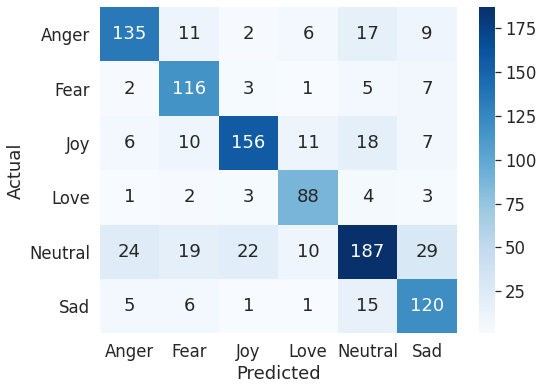

Training finished!


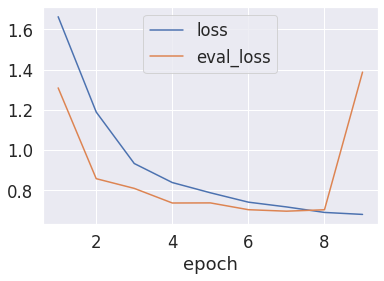

Total time: 5.0232975880304975 minutes


In [12]:
#3 FacebookAI/xlm-roberta-base peft

main(
    model_name = 'FacebookAI/xlm-roberta-base',
    output_dir = 'p-emotcls-xlm-r-base',
    best_params = 'best_params/p-xlm-r-base.json'
)

{'num_train_epochs': 10, 'learning_rate': 0.0001, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'weight_decay': 0.07667430551681942}


Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-ber

trainable params: 299,526 || all params: 178,157,580 || trainable%: 0.16812419656800456


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index, token_type_ids. If tweet, index, token_type_ids are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4956
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 390
  Number of trainable parameters = 299526
Automatic Weights & Biases logging enabled, to 

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.751500,1.726534,0.280603,0.046811,0.166667,0.073093
2,1.705500,1.669901,0.306026,0.365767,0.204471,0.148665
3,1.643900,1.617818,0.360640,0.320106,0.276513,0.237339
4,1.593000,1.564869,0.396422,0.354001,0.312262,0.291376
5,1.534700,1.506187,0.424670,0.343608,0.354500,0.337683
6,1.489800,1.474815,0.438795,0.529818,0.371802,0.355727
7,1.452000,1.444844,0.450094,0.504852,0.380087,0.371642
8,1.423200,1.423590,0.481168,0.472046,0.424518,0.419453
9,1.399800,1.412295,0.487759,0.496390,0.431453,0.426175
10,1.395800,1.411522,0.483992,0.497193,0.426158,0.425185


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index, token_type_ids. If tweet, index, token_type_ids are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 128


Classification Report:
              precision    recall  f1-score   support

       Anger     0.0000    0.0000    0.0000       176
        Fear     0.0000    0.0000    0.0000       147
         Joy     0.0000    0.0000    0.0000       177
        Love     0.0000    0.0000    0.0000       115
     Neutral     0.2809    1.0000    0.4386       298
         Sad     0.0000    0.0000    0.0000       149

    accuracy                         0.2806      1062
   macro avg     0.0468    0.1667    0.0731      1062
weighted avg     0.0788    0.2806    0.1231      1062



/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Classification Report:
              precision    recall  f1-score   support

       Anger     0.2333    0.1989    0.2147       176
        Fear     0.5000    0.0068    0.0134       147
         Joy     0.4000    0.1017    0.1622       177
        Love     0.0000    0.0000    0.0000       115
     Neutral     0.3113    0.8993    0.4625       298
         Sad     0.7500    0.0201    0.0392       149

    accuracy                         0.3060      1062
   macro avg     0.3658    0.2045    0.1487      1062
weighted avg     0.3671    0.3060    0.1997      1062



/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Classification Report:
              precision    recall  f1-score   support

       Anger     0.2500    0.1477    0.1857       176
        Fear     0.3333    0.1224    0.1791       147
         Joy     0.2977    0.5198    0.3786       177
        Love     0.0000    0.0000    0.0000       115
     Neutral     0.4080    0.7886    0.5378       298
         Sad     0.6316    0.0805    0.1429       149

    accuracy                         0.3606      1062
   macro avg     0.3201    0.2765    0.2373      1062
weighted avg     0.3403    0.3606    0.2896      1062



/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Classification Report:
              precision    recall  f1-score   support

       Anger     0.2486    0.2557    0.2521       176
        Fear     0.3662    0.1769    0.2385       147
         Joy     0.4719    0.4746    0.4732       177
        Love     0.0000    0.0000    0.0000       115
     Neutral     0.4087    0.8188    0.5453       298
         Sad     0.6286    0.1477    0.2391       149

    accuracy                         0.3964      1062
   macro avg     0.3540    0.3123    0.2914      1062
weighted avg     0.3734    0.3964    0.3402      1062



/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Classification Report:
              precision    recall  f1-score   support

       Anger     0.2737    0.2955    0.2842       176
        Fear     0.3543    0.3061    0.3285       147
         Joy     0.5054    0.5254    0.5152       177
        Love     0.0000    0.0000    0.0000       115
     Neutral     0.4657    0.7517    0.5751       298
         Sad     0.4625    0.2483    0.3231       149

    accuracy                         0.4247      1062
   macro avg     0.3436    0.3545    0.3377      1062
weighted avg     0.3742    0.4247    0.3851      1062



/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Classification Report:
              precision    recall  f1-score   support

       Anger     0.2635    0.2216    0.2407       176
        Fear     0.4000    0.3673    0.3830       147
         Joy     0.4643    0.5876    0.5187       177
        Love     1.0000    0.0174    0.0342       115
     Neutral     0.4678    0.7550    0.5777       298
         Sad     0.5833    0.2819    0.3801       149

    accuracy                         0.4388      1062
   macro avg     0.5298    0.3718    0.3557      1062
weighted avg     0.4978    0.4388    0.3985      1062



Saving model checkpoint to p-emotcls-bert-base/checkpoint-234
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-bert-base/checkpoint-234/tokenizer_config.json
Special tokens file saved in p-emotcls-bert-base/checkpoint-234/special_tokens_map.json
Deleting older checkpoint [p-emotcls-bert-base/checkpoint-195] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index, token_type_ids. If tweet, index, token_type_ids are not expected by `PeftModelForSequenceClassification.forward`,  you can sa

Classification Report:
              precision    recall  f1-score   support

       Anger     0.2774    0.2443    0.2598       176
        Fear     0.4766    0.3469    0.4016       147
         Joy     0.5161    0.5424    0.5289       177
        Love     0.7500    0.0261    0.0504       115
     Neutral     0.4521    0.7919    0.5756       298
         Sad     0.5568    0.3289    0.4135       149

    accuracy                         0.4501      1062
   macro avg     0.5049    0.3801    0.3716      1062
weighted avg     0.4842    0.4501    0.4118      1062



Saving model checkpoint to p-emotcls-bert-base/checkpoint-273
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-bert-base/checkpoint-273/tokenizer_config.json
Special tokens file saved in p-emotcls-bert-base/checkpoint-273/special_tokens_map.json
Deleting older checkpoint [p-emotcls-bert-base/checkpoint-234] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index, token_type_ids. If tweet, index, token_type_ids are not expected by `PeftModelForSequenceClassification.forward`,  you can sa

Classification Report:
              precision    recall  f1-score   support

       Anger     0.3012    0.2841    0.2924       176
        Fear     0.4493    0.4218    0.4351       147
         Joy     0.5303    0.5932    0.5600       177
        Love     0.5000    0.0870    0.1481       115
     Neutral     0.5261    0.7450    0.6167       298
         Sad     0.5254    0.4161    0.4644       149

    accuracy                         0.4812      1062
   macro avg     0.4720    0.4245    0.4195      1062
weighted avg     0.4760    0.4812    0.4563      1062



Saving model checkpoint to p-emotcls-bert-base/checkpoint-312
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-bert-base/checkpoint-312/tokenizer_config.json
Special tokens file saved in p-emotcls-bert-base/checkpoint-312/special_tokens_map.json
Deleting older checkpoint [p-emotcls-bert-base/checkpoint-273] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index, token_type_ids. If tweet, index, token_type_ids are not expected by `PeftModelForSequenceClassification.forward`,  you can sa

Classification Report:
              precision    recall  f1-score   support

       Anger     0.3306    0.2330    0.2733       176
        Fear     0.4481    0.4694    0.4585       147
         Joy     0.5674    0.5706    0.5690       177
        Love     0.6316    0.1043    0.1791       115
     Neutral     0.5044    0.7685    0.6090       298
         Sad     0.4962    0.4430    0.4681       149

    accuracy                         0.4878      1062
   macro avg     0.4964    0.4315    0.4262      1062
weighted avg     0.4909    0.4878    0.4596      1062



Saving model checkpoint to p-emotcls-bert-base/checkpoint-351
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-bert-base/checkpoint-351/tokenizer_config.json
Special tokens file saved in p-emotcls-bert-base/checkpoint-351/special_tokens_map.json
Deleting older checkpoint [p-emotcls-bert-base/checkpoint-312] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index, token_type_ids. If tweet, index, token_type_ids are not expected by `PeftModelForSequenceClassification.forward`,  you can sa

Classification Report:
              precision    recall  f1-score   support

       Anger     0.3143    0.2500    0.2785       176
        Fear     0.4697    0.4218    0.4444       147
         Joy     0.5417    0.5876    0.5637       177
        Love     0.6190    0.1130    0.1912       115
     Neutral     0.4946    0.7685    0.6018       298
         Sad     0.5439    0.4161    0.4715       149

    accuracy                         0.4840      1062
   macro avg     0.4972    0.4262    0.4252      1062
weighted avg     0.4895    0.4840    0.4573      1062



Saving model checkpoint to p-emotcls-bert-base/checkpoint-390
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-bert-base/checkpoint-390/tokenizer_config.json
Special tokens file saved in p-emotcls-bert-base/checkpoint-390/special_tokens_map.json
Deleting older checkpoint [p-emotcls-bert-base/checkpoint-351] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from p-emotcls-bert-base/checkpoint-390 (score: 1.4115222692489624).
Saving model checkpoint to p-emotcls-bert-base
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in p-emotcls-bert-base/tokenizer_config.json
Special tokens file saved in p-emotcls-bert-base/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index

The following columns in the test set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: tweet, index, token_type_ids. If tweet, index, token_type_ids are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1062
  Batch size = 128


Classification Report:
              precision    recall  f1-score   support

       Anger     0.3358    0.2556    0.2902       180
        Fear     0.4403    0.4403    0.4403       134
         Joy     0.6215    0.6394    0.6303       208
        Love     0.6000    0.1485    0.2381       101
     Neutral     0.4855    0.7457    0.5881       291
         Sad     0.4762    0.3378    0.3953       148

    accuracy                         0.4896      1062
   macro avg     0.4932    0.4279    0.4304      1062
weighted avg     0.4906    0.4896    0.4671      1062

{'eval_loss': 1.3804205656051636, 'eval_accuracy': 0.4896421845574388, 'eval_precision': 0.4932015578481703, 'eval_recall': 0.4278890494363761, 'eval_f1': 0.4303798528427594, 'eval_runtime': 3.8669, 'eval_samples_per_second': 274.64, 'eval_steps_per_second': 2.327, 'epoch': 10.0}


/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

       Anger     0.3358    0.2556    0.2902       180
        Fear     0.4403    0.4403    0.4403       134
         Joy     0.6215    0.6394    0.6303       208
        Love     0.6000    0.1485    0.2381       101
     Neutral     0.4855    0.7457    0.5881       291
         Sad     0.4762    0.3378    0.3953       148

    accuracy                         0.4896      1062
   macro avg     0.4932    0.4279    0.4304      1062
weighted avg     0.4906    0.4896    0.4671      1062



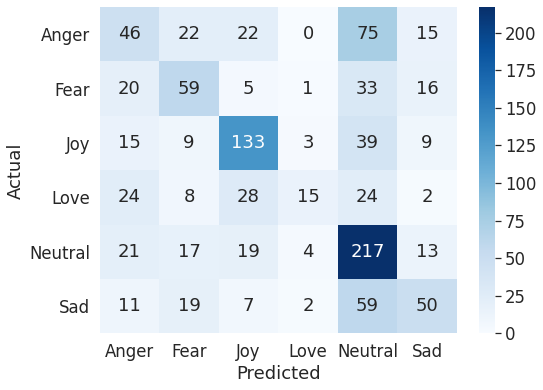

Training finished!


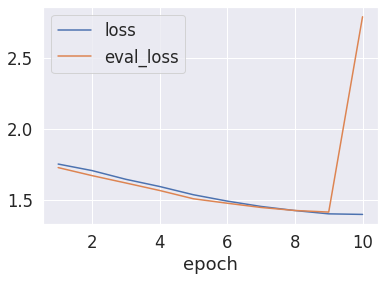

Total time: 5.800148745377858 minutes


In [10]:
#4 google-bert/bert-base-multilingual-cased peft

main(
    model_name = 'google-bert/bert-base-multilingual-cased',
    output_dir = 'p-emotcls-bert-base',
    best_params = 'best_params/p-mbert.json'
)